# Classificação

Baseado no trabalho de [Aurélien Geron](https://github.com/ageron/handson-ml).

## Setup

Primeiro, vamos garantir que este notebook funcione bem tanto no python 2 quanto no 3, importe alguns módulos comuns, garanta que o MatplotLib plote figuras em linha e prepare uma função para salvar os números:

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import cluster
from sklearn import datasets
from sklearn import metrics
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [7]:
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

# MNINST

## Load MNIST dataset

In [8]:
# Load in the `digits` data
digits = datasets.load_digits()
# Get the keys of the `digits` data
print(digits.keys())

# Print out the data
print(digits.data)

# Print out the target values
print(digits.target)

# Print out the description of the `digits` data
print(digits.DESCR)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]
Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted for

In [9]:
# Isolate the `digits` data
digits_data = digits.data

# Inspect the shape
print(digits_data.shape)

# Isolate the target values with `target`
digits_target = digits.target

# Inspect the shape
print(digits_target.shape)

# Print the number of unique labels
number_digits = len(np.unique(digits.target))

# Isolate the `images`
digits_images = digits.images

# Inspect the shape
print(digits_images.shape)

(1797, 64)
(1797,)
(1797, 8, 8)


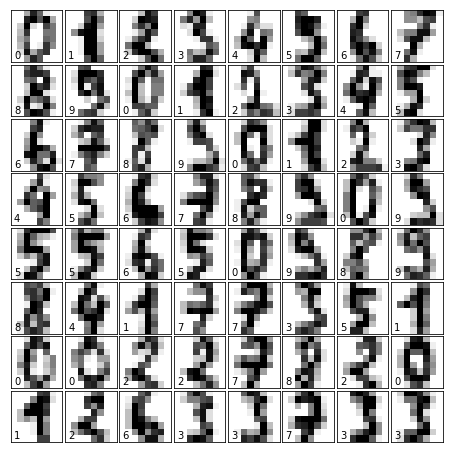

In [10]:
# Figure size (width, height) in inches
fig = plt.figure(figsize=(6, 6))

# Adjust the subplots 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# For each of the 64 images
for i in range(64):
    # Initialize the subplots: add a subplot in the grid of 8 by 8, at the i+1-th position
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    # Display an image at the i-th position
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

# Show the plot
plt.show()

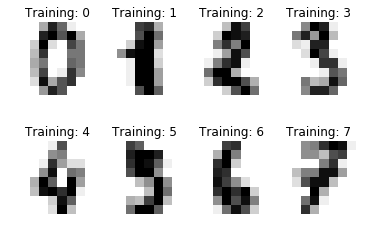

In [11]:
# Join the images and target labels in a list
images_and_labels = list(zip(digits.images, digits.target))

# for every element in the list
for index, (image, label) in enumerate(images_and_labels[:8]):
    # initialize a subplot of 2X4 at the i+1-th position
    plt.subplot(2, 4, index + 1)
    # Don't plot any axes
    plt.axis('off')
    # Display images in all subplots 
    plt.imshow(image, cmap=plt.cm.gray_r,interpolation='nearest')
    # Add a title to each subplot
    plt.title('Training: ' + str(label))

# Show the plot
plt.show()

## Explorando o Dataset

### PCA (Principal Component Analysis)

Como o conjunto de dados de dígitos contém 64 features (no nosso caso, os pixels), visualizar a relação entre os dígitos pode ser uma tarefa desafiadora. Você pode imaginar que é muito difícil entender a estrutura e manter a visão geral dos dados dos dígitos. Nesses casos, é dito que você está trabalhando com um conjunto de dados de alta dimensão.

A alta dimensionalidade dos dados é um resultado direto da tentativa de descrever os objetos por meio de um conjunto de features. Outros exemplos de dados de alta dimensão são, por exemplo, dados financeiros, dados climáticos, neuroimagem.

Dado a complexidade, vamos usarAnálise de componentes principais (PCA) para visualiazar os dados. A ideia no PCA é encontrar uma combinação linear da variáveis que contém a maior parte das informações. Uma nova variável chamada de “componente principal” pode substituir as duas variáveis originais.

[Para saber mais sobre PCA](https://www.lauradhamilton.com/introduction-to-principal-component-analysis-pca).

In [12]:
# Create a Randomized PCA model that takes two components
randomized_pca = PCA(n_components=2)

# Fit and transform the data to the model
reduced_data_rpca = randomized_pca.fit_transform(digits.data)

# Create a regular PCA model 
pca = PCA(n_components=2)

# Fit and transform the data to the model
reduced_data_pca = pca.fit_transform(digits.data)

# Inspect the shape
reduced_data_pca.shape

# Print out the data
print(reduced_data_rpca)
print(reduced_data_pca)

[[ -1.2594653   21.27488212]
 [  7.95761311 -20.76869858]
 [  6.99192097  -9.95598519]
 ...
 [ 10.80128296  -6.96025143]
 [ -4.87208935  12.42394564]
 [ -0.34439169   6.36554929]]
[[ -1.25946433  21.27488242]
 [  7.95761454 -20.76869802]
 [  6.99191826  -9.95598626]
 ...
 [ 10.80128334  -6.96025327]
 [ -4.87210014  12.42395464]
 [ -0.34439216   6.36554812]]


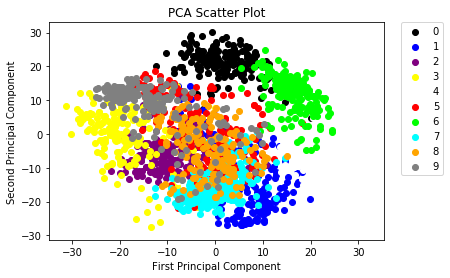

In [13]:
colors = ['black', 'blue', 'purple', 'yellow', 'white', 'red', 'lime', 'cyan', 'orange', 'gray']
for i in range(len(colors)):
    x = reduced_data_rpca[:, 0][digits.target == i]
    y = reduced_data_rpca[:, 1][digits.target == i]
    plt.scatter(x, y, c=colors[i])
plt.legend(digits.target_names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

## Normalização dos dados

Vamos pré-processar os dados. Você pode padronizar os dados de dígitos usando, por exemplo, o método `scale`.

Ao dimensionar os dados, você desloca a distribuição de cada atributo para ter uma média de zero e um desvio padrão de um (variação de unidade).

In [14]:
# Apply `scale()` to the `digits` data
data = scale(digits.data)

## Split data

In [15]:
# Split the `digits` data into training and test sets
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(data, digits.target, digits.images, test_size=0.25, random_state=42)

In [16]:
# Number of training features
n_samples, n_features = X_train.shape

# Print out `n_samples`
print(n_samples)

# Print out `n_features`
print(n_features)

# Number of Training labels
n_digits = len(np.unique(y_train))

# Inspect `y_train`
print(len(y_train))

1347
64
1347


## Clustering

Vamos usar `KMeans` do módulo `sklearn.cluster` para configurar o modelo. Você verá que há três argumentos que são passados para esse método: `init`, `n_clusters` e `random_state`.

O `init` indica o método de inicialização, `n_clusters` está definido como `10`. Esse número não apenas indica o número de clusters ou grupos que você deseja que seus dados formem, mas também o número de __centróides__ a serem gerados. O centróide de cluster é o meio do cluster.

In [17]:
# Create the KMeans model
clf = cluster.KMeans(init='k-means++', n_clusters=10, random_state=42)

# Fit the training data to the model
clf.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

#### Visualizando as centróides

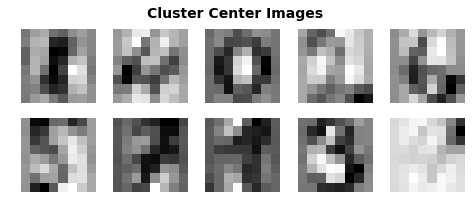

In [18]:
# Figure size in inches
fig = plt.figure(figsize=(8, 3))

# Add title
fig.suptitle('Cluster Center Images', fontsize=14, fontweight='bold')

# For all labels (0-9)
for i in range(10):
    # Initialize subplots in a grid of 2X5, at i+1th position
    ax = fig.add_subplot(2, 5, 1 + i)
    # Display images
    ax.imshow(clf.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)
    # Don't show the axes
    plt.axis('off')

# Show the plot
plt.show()

#### Prevendo as categorias dos dígitos

In [19]:
# Predict the labels for `X_test`
y_pred=clf.predict(X_test)

# Print out the first 100 instances of `y_pred`
print(y_pred[:100])

# Print out the first 100 instances of `y_test`
print(y_test[:100])

[4 8 8 9 3 3 5 8 5 3 0 7 1 2 1 3 8 6 8 8 1 5 8 6 5 4 8 5 4 8 1 8 3 1 1 4 8
 1 6 4 4 8 0 8 4 7 8 2 4 5 5 0 8 5 4 2 8 2 2 7 2 1 5 3 1 5 6 2 6 8 8 8 8 6
 6 2 1 5 8 8 8 2 3 8 8 2 4 1 1 8 0 3 7 8 8 3 8 2 1 1]
[6 9 3 7 2 1 5 2 5 2 1 9 4 0 4 2 3 7 8 8 4 3 9 7 5 6 3 5 6 3 4 9 1 4 4 6 9
 4 7 6 6 9 1 3 6 1 3 0 6 5 5 1 9 5 6 0 9 0 0 1 0 4 5 2 4 5 7 0 7 5 9 5 5 4
 7 0 4 5 5 9 9 0 2 3 8 0 6 4 4 9 1 2 8 3 5 2 9 0 4 4]


Visualizando as categorias inferidas:

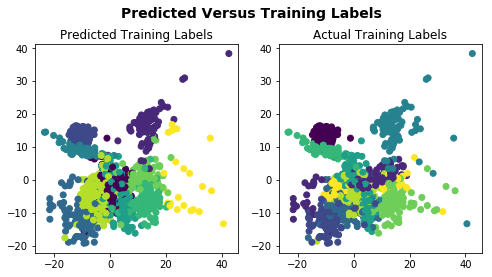

In [20]:
# Create an isomap and fit the `digits` data to it
X_iso = Isomap(n_neighbors=10).fit_transform(X_train)

# Compute cluster centers and predict cluster index for each sample
clusters = clf.fit_predict(X_train)

# Create a plot with subplots in a grid of 1X2
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Adjust layout
fig.suptitle('Predicted Versus Training Labels', fontsize=14, fontweight='bold')
fig.subplots_adjust(top=0.85)

# Add scatterplots to the subplots 
ax[0].scatter(X_iso[:, 0], X_iso[:, 1], c=clusters)
ax[0].set_title('Predicted Training Labels')
ax[1].scatter(X_iso[:, 0], X_iso[:, 1], c=y_train)
ax[1].set_title('Actual Training Labels')

# Show the plots
plt.show()

## Avaliando o modelo
### Métricas de clustering

Métricas para avaliação de clusters:

In [21]:
print('% 9s' % 'inertia    homo   compl  v-meas     ARI AMI  silhouette')
print('%i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          %(clf.inertia_,
      metrics.homogeneity_score(y_test, y_pred),
      metrics.completeness_score(y_test, y_pred),
      metrics.v_measure_score(y_test, y_pred),
      metrics.adjusted_rand_score(y_test, y_pred),
      metrics.adjusted_mutual_info_score(y_test, y_pred),
      metrics.silhouette_score(X_test, y_pred, metric='euclidean')))

inertia    homo   compl  v-meas     ARI AMI  silhouette
54276   0.688   0.733   0.710   0.567   0.674    0.146


* A medida de homogeneidade (homogeneity_score) indica em que medida todos os clusters contêm apenas pontos de dados que são membros de uma única categoria.
* A medida de integralidade (completeness_score) mede até que ponto todos os pontos de dados que são membros de uma determinada categoria também são elementos do mesmo cluster.
* A medida V (v_measure_score) é a média harmônica entre homogeneidade e completude.
* A medida adjusted_rand_score mede a similaridade entre dois agrupamentos e considera todos os pares de amostras e pares de contagem que são atribuídos nos mesmos ou diferentes agrupamentos nos agrupamentos previstos e verdadeiros.
* A medida da Informação Mútua Ajustada (adjusted_mutual_info_score) é usada para comparar clusters. Ele mede a similaridade entre os pontos de dados que estão nos agrupamentos, representando agrupamentos aleatórios e assume um valor máximo de 1 quando os agrupamentos são equivalentes.
* A medida da silhueta (silhouette_score) mede a similaridade de um objeto ao seu próprio cluster em comparação a outros clusters. As pontuações da silhueta variam de -1 a 1, em que um valor mais alto indica que o objeto é mais compatível com seu próprio cluster e pior comparado aos clusters vizinhos. Se muitos pontos tiverem um valor alto, a configuração do clusteirng é boa.

### Matriz de confusão

In [22]:
confusion_mat = metrics.confusion_matrix(y_test, y_pred)
print(confusion_mat)

[[ 0  0 43  0  0  0  0  0  0  0]
 [20  0  0  7  0  0  0 10  0  0]
 [ 5  0  0 31  0  0  0  1  1  0]
 [ 1  0  0  1  0  1  4  0 39  0]
 [ 1 50  0  0  0  0  1  2  0  1]
 [ 1  0  0  0  1 41  0  0 16  0]
 [ 0  0  1  0 44  0  0  0  0  0]
 [ 0  0  0  0  0  1 34  1  0  5]
 [21  0  0  0  0  3  1  2 11  0]
 [ 0  0  0  0  0  2  3  3 40  0]]


Text(0.5,42,'Predicted label')

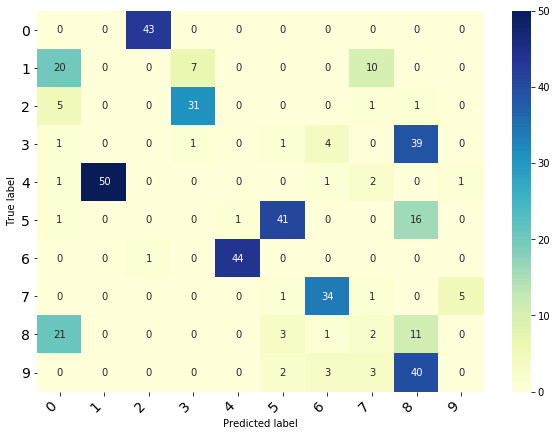

In [23]:
df_cm = pd.DataFrame(confusion_mat, index=digits.target_names, columns=digits.target_names)
fig = plt.figure(figsize=(10,7))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Métricas

In [25]:
print(metrics.classification_report(y_pred, y_test, digits.target_names))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        49
          1       0.00      0.00      0.00        50
          2       0.00      0.00      0.00        44
          3       0.02      0.03      0.02        39
          4       0.00      0.00      0.00        45
          5       0.69      0.85      0.77        48
          6       0.00      0.00      0.00        43
          7       0.02      0.05      0.03        19
          8       0.29      0.10      0.15       107
          9       0.00      0.00      0.00         6

avg / total       0.15      0.12      0.12       450



## SVM

Agora é com você :)

In [42]:
# Split the `digits` data into training and test sets
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(data, digits.target, digits.images, test_size=0.25, random_state=42)

# Create the SVC model 
svc_model = svm.SVC(gamma=0.001, C=100., kernel='linear')

# Fit the data to the SVC model
svc_model.fit(X_train, y_train)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)